In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('/home/suyog/github/Machine_Learning_with_Python/data/av_hackathon_train_modified.csv')
target = 'Disbursed'
IDcol = 'ID'

/home/suyog/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/suyog/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### func to be used later for metrics

In [3]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds) #show_progress alternative
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Parameter Tuning

### 1: Fix learning rate and number of estimators for tuning tree-based parameters

/home/suyog/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9854
AUC Score (Train): 0.898282


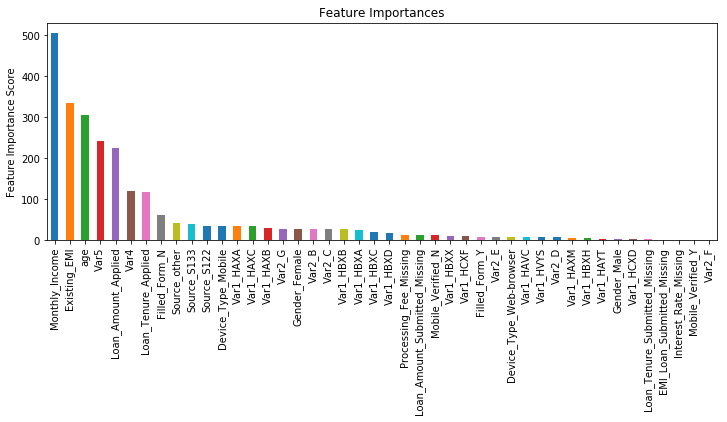

In [4]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

### 2: Tune max_depth and min_child_weight

We tune these first as they will have the highest impact on model outcome

In order to decide on boosting parameters, we need to set some initial values of other parameters

In [10]:
# param_test1 = {
#  'max_depth':list(range(3,10,2)),
#  'min_child_weight':list(range(1,6,2))
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch1.fit(train[predictors],train[target])
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

optimum values as 5 for max_depth and 5 for min_child_weight. cv score: 0.8412

#### regular compute resource

In [ ]:
param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.2, n_estimators=40, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Note: we are getting different optimum value set now!! This is trade off ;)

#### performing test around neighbour values, since we used offset of 2

In [ ]:
# param_test2 = {
#  'max_depth':[4,5,6],
#  'min_child_weight':[4,5,6]
# }
# gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
#  min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch2.fit(train[predictors],train[target])
# gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

optimum values as 4 for max_depth and 6 for min_child_weight. cv score: 0.8412

6 is max value,lets try some values above it for possible optimum value

In [ ]:
# param_test2b = {
#  'min_child_weight':[6,8,10,12]
# }
# gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
#  min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch2b.fit(train[predictors],train[target])

In [ ]:
# modelfit(gsearch3.best_estimator_, train, predictors)
# gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

we get 6 as the optimal value.

#### regular compute resource: (max_depth = 5, min_child = 1) performing test around neighbour values, since we used offset of 2

In [ ]:
#still taking long. changing params.
param_test2 = {
 'max_depth':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.2, n_estimators=40, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

for regular compute resource: {'max_depth': , 'min_child_weight': 1}

### 3: Tuning gamma

In [12]:
# param_test3 = {
#  'gamma':[i/10.0 for i in range(0,5)]
# }
# gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
#  min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch3.fit(train[predictors],train[target])
# gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

gamma = 0, cv score: 0.8412

For regular compute resource :)

In [ ]:
# param_test3 = {
#  'gamma':[i/10.0 for i in list(range(0,5))]
# }
# gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.2, n_estimators=40, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch3.fit(train[predictors],train[target])
# gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

#### This shows that our original value of gamma, i.e. 0 is the optimum one. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

/home/suyog/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9854
AUC Score (Train): 0.893169


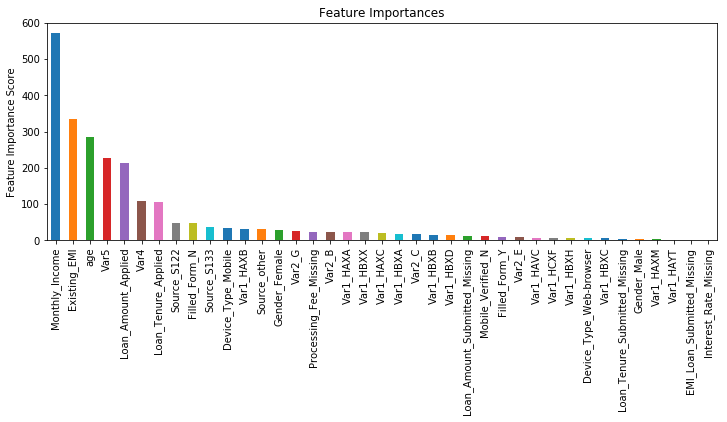

In [16]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

Here, we can see the improvement in score. So the final parameters are:
    max_depth: 4
    min_child_weight: 6
    gamma: 0


for regular compute resource: max_depth: 5 min_child_weight: 1 gamma: 


### Step 4: Tune subsample and colsample_bytree

The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.

In [19]:
# param_test4 = {
#  'subsample':[i/10.0 for i in range(6,10)],
#  'colsample_bytree':[i/10.0 for i in range(6,10)]
# }
# gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
#  min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch4.fit(train[predictors],train[target])
# gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

Here, we found 0.8 as the optimum value for both subsample and colsample_bytree. Now we should try values in 0.05 interval around these.

In [20]:
# param_test5 = {
#  'subsample':[i/100.0 for i in range(75,90,5)],
#  'colsample_bytree':[i/100.0 for i in range(75,90,5)]
# }
# gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
#  min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch5.fit(train[predictors],train[target])

Again we got the same values as before. Thus the optimum values are:
    subsample: 0.8
    colsample_bytree: 0.8

### 5: Tuning Regularization Parameters

Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

In [21]:
# param_test6 = {
#  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# }
# gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
#  min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch6.fit(train[predictors],train[target])
# gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

reg_alpha = 0.01, cv = 0.8408

We can see that the CV score is less than the previous case. But the values tried are very widespread, we should try values closer to the optimum here (0.01) to see if we get something better.

In [22]:
# param_test7 = {
#  'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
# }
# gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
#  min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch7.fit(train[predictors],train[target])
# gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
reg_alpha = 0.005, cv = 0.84118

You can see that we got a better CV. Now we can apply this regularization in the model and look at the impact:

/home/suyog/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9854
AUC Score (Train): 0.890932


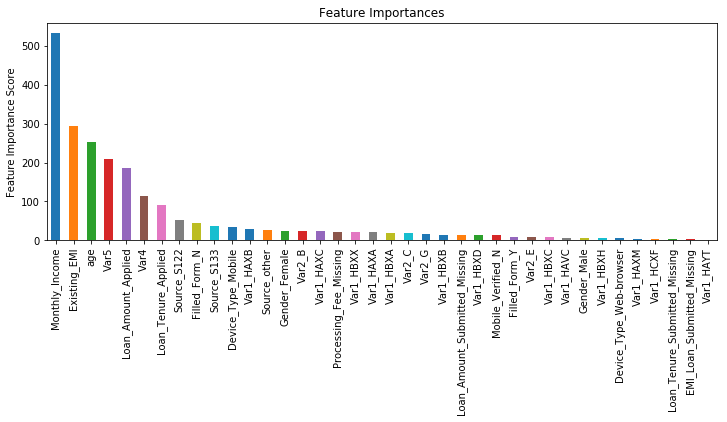

In [23]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

Again we can see slight improvement in the score.

### 6: Reducing Learning Rate

In [ ]:
Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

In [ ]:
# xgb4 = XGBClassifier(
#  learning_rate =0.01,
#  n_estimators=5000,
#  max_depth=4,
#  min_child_weight=6,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  reg_alpha=0.005,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)
# modelfit(xgb4, train, predictors)

Now we can see a significant boost in performance and the effect of parameter tuning is clearer.

As we come to the end, I would like to share 2 key thoughts:

1. It is difficult to get a very big leap in performance by just using parameter tuning or slightly better models. The max score for GBM was 0.8487 while XGBoost gave 0.8494. This is a decent improvement but not something very substantial.

2.A significant jump can be obtained by other methods like feature engineering, creating ensemble of models, stacking, etc

### some compute is pending because of limited processing power of machine